In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [22]:
from sqlalchemy import inspect
inspector = inspect(engine)

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [17]:
type(Measurement)

sqlalchemy.ext.declarative.api.DeclarativeMeta

In [12]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [25]:
# Get a list of column names and types
tablesNames = Base.classes.keys()

for tableName in tablesNames:
    print(f'----------- {tableName} -----------')
    columns = inspector.get_columns(tableName)
#     print(columns)
    for column in columns:
        print(column['name'], column["type"])

----------- measurement -----------
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
----------- station -----------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [29]:
measureColumns = [Measurement.id, Measurement.station, Measurement.date, Measurement.prcp, Measurement.tobs]

In [68]:
stationColumns = [Station.id, Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation]

In [30]:
ms = session.query(*measureColumns).limit(10).all()
for m in ms:
    print(m)

(1, 'USC00519397', '2010-01-01', 0.08, 65.0)
(2, 'USC00519397', '2010-01-02', 0.0, 63.0)
(3, 'USC00519397', '2010-01-03', 0.0, 74.0)
(4, 'USC00519397', '2010-01-04', 0.0, 76.0)
(5, 'USC00519397', '2010-01-06', None, 73.0)
(6, 'USC00519397', '2010-01-07', 0.06, 70.0)
(7, 'USC00519397', '2010-01-08', 0.0, 64.0)
(8, 'USC00519397', '2010-01-09', 0.0, 68.0)
(9, 'USC00519397', '2010-01-10', 0.0, 73.0)
(10, 'USC00519397', '2010-01-11', 0.01, 64.0)


# Exploratory Climate Analysis

In [57]:
# last point in the database
lastPoint = session.query(Measurement.date).\
    order_by(Measurement.date.desc()).limit(1).all()
print(lastPoint)

[('2017-08-23',)]


In [58]:
# Calculate the date 1 year ago from the last data point in the database
oneYearAgo = '2016-08-23'

In [59]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Perform a query to retrieve the data and precipitation scores
# session.query(*measureColumns).\
#     filter(Measurement.date > oneYearAgo).\
#     order_by(Measurement.date).all()

statement = session.query(*measureColumns).\
    filter(Measurement.date >= oneYearAgo).\
    order_by(Measurement.date.desc()).statement

last12MonthsPrecipitation = pd.read_sql_query(statement, session.bind)
last12MonthsPrecipitation.head(5)


,id,station,date,prcp,tobs
0,2724,USC00519397,2017-08-23,0.00,81.0
1,7635,USC00514830,2017-08-23,0.00,82.0
2,12187,USC00519523,2017-08-23,0.08,82.0
3,19550,USC00516128,2017-08-23,0.45,76.0
4,2723,USC00519397,2017-08-22,0.00,82.0


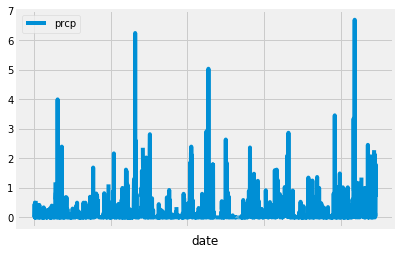

In [60]:
# Use Pandas Plotting with Matplotlib to plot the data
last12MonthsPrecipitation.plot(x= "date", y="prcp")

![precipitation](Images/precipitation.png)

In [61]:
# Use Pandas to calcualte the summary statistics for the precipitation data
last12MonthsPrecipitation["prcp"].describe()

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64

![describe](Images/describe.png)

In [67]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.station)).scalar()
# last12MonthsPrecipitation.count()

9

In [94]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
# session.query(*stationColumns).group_by()

statement = session.query(*measureColumns).\
    order_by(Measurement.date.desc()).statement

fullDataset = pd.read_sql_query(statement, session.bind)
fullDataset.head(5)

fullDataset.groupby("station").count().sort_values("tobs", ascending=False)["tobs"]

station
USC00519281    2772
USC00519397    2724
USC00513117    2709
USC00519523    2669
USC00516128    2612
USC00514830    2202
USC00511918    1979
USC00517948    1372
USC00518838     511
Name: tobs, dtype: int64

In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [106]:
mostActiveStation = (fullDataset.groupby("station").count().sort_values("tobs", ascending=False)["tobs"]).reset_index().loc[0].station
mostActiveStation

'USC00519281'

In [107]:
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))\
    .filter(Measurement.station == mostActiveStation).all()

[(54.0, 85.0, 71.66378066378067)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?


[(54.0, 85.0, 71.66378066378067)]

In [108]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
statement = session.query(*measureColumns).\
    filter(Measurement.station == mostActiveStation).\
    filter(Measurement.date >= oneYearAgo).\
    order_by(Measurement.date.desc()).statement

last12MonthsOfMostActiveStation = pd.read_sql_query(statement, session.bind)
last12MonthsOfMostActiveStation.head(5)

,id,station,date,prcp,tobs
0,14959,USC00519281,2017-08-18,0.06,79.0
1,14958,USC00519281,2017-08-17,0.01,76.0
2,14957,USC00519281,2017-08-16,0.12,76.0
3,14956,USC00519281,2017-08-15,0.32,77.0
4,14955,USC00519281,2017-08-14,0.00,77.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D68E9C8550>]],
      dtype=object)

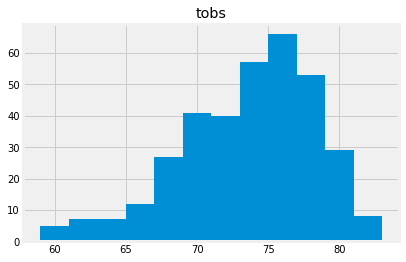

In [116]:
last12MonthsOfMostActiveStation.hist(column="tobs", bins=12)

![precipitation](Images/station-histogram.png)

In [126]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [138]:
temps = calc_temps('2012-02-28', '2012-03-05')
temps

[(62.0, 69.57142857142857, 74.0)]

In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


62.0 68.36585365853658 74.0


<IPython.core.display.Javascript object>


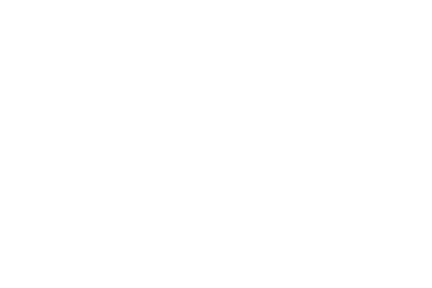

<IPython.core.display.Javascript object>


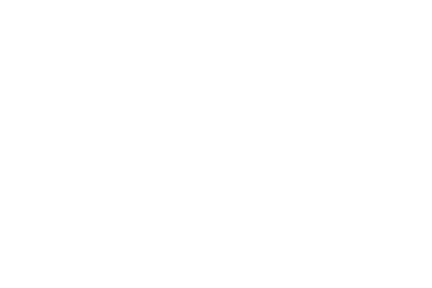

In [151]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
ye = temps[0][2] - temps[0][0]
ye

# plt.figure(figsize=(4,5))

# plt.title("Trip Avg Temp")
# plt.ylabel("Temp (F)")

# plt.bar(1, temps[0][1], yerr=ye, color='r', alpha=0.5) 
# plt.xlim(0,2)
# plt.ylim(0,100)

# plt.show()

pd.DataFrame({
    "trip avg": [temps[0][1]],
    "bar": [1],
    "yerror": [ye]
}).plot(y="trip avg", x="bar", yerr="yerror")

In [19]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


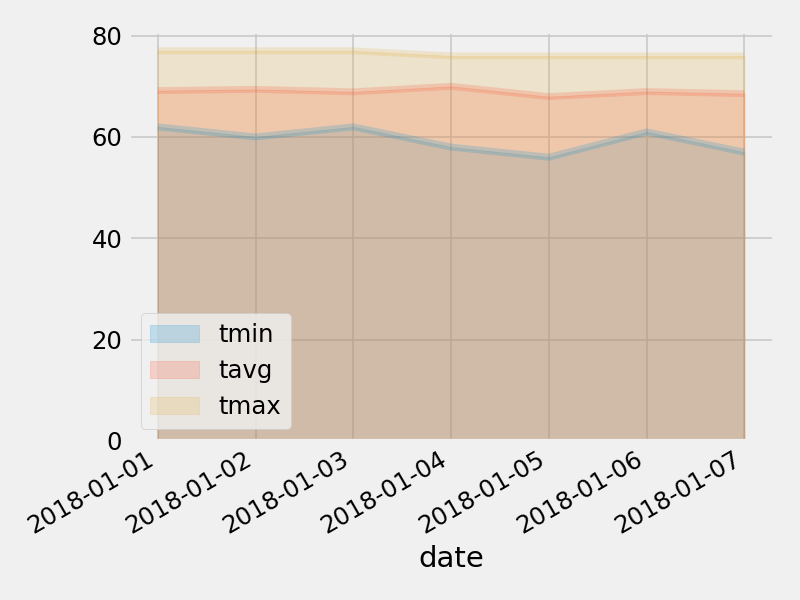

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
